In [1]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'MNIST', 'CNN_3', 'Attack'
Gdrive = '/content/drive/MyDrive/Colab Notebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, SSIM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
def reconstruct(decoders):
  image = next(iter(DataLoader(testset)))[0]
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.figure(figsize=(32,8))
  for i in range(num_clients):
    plt.subplot(1, num_clients, i+1)
    with torch.no_grad():
      network.clients[i].eval(), decoders[i].eval()
      output = decoders[i](network.clients[i](image.cuda()))
    plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
    plt.title('{}, {:.0e}'.format(ssim(image, output.cpu(), 1.0), F.mse_loss(image, output.cpu())))

#Fashion

In [6]:
dataset, testset = loadDataset('Fashion')

100%|██████████| 26421880/26421880 [00:01<00:00, 15738563.76it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270939.91it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4968841.03it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17918902.07it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [7]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [8]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

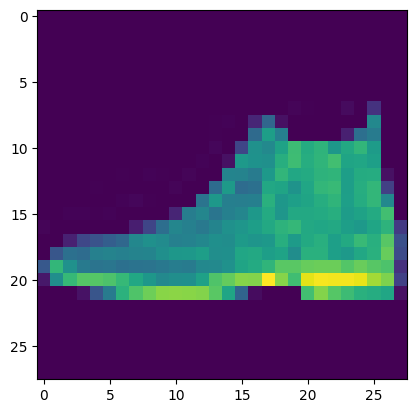

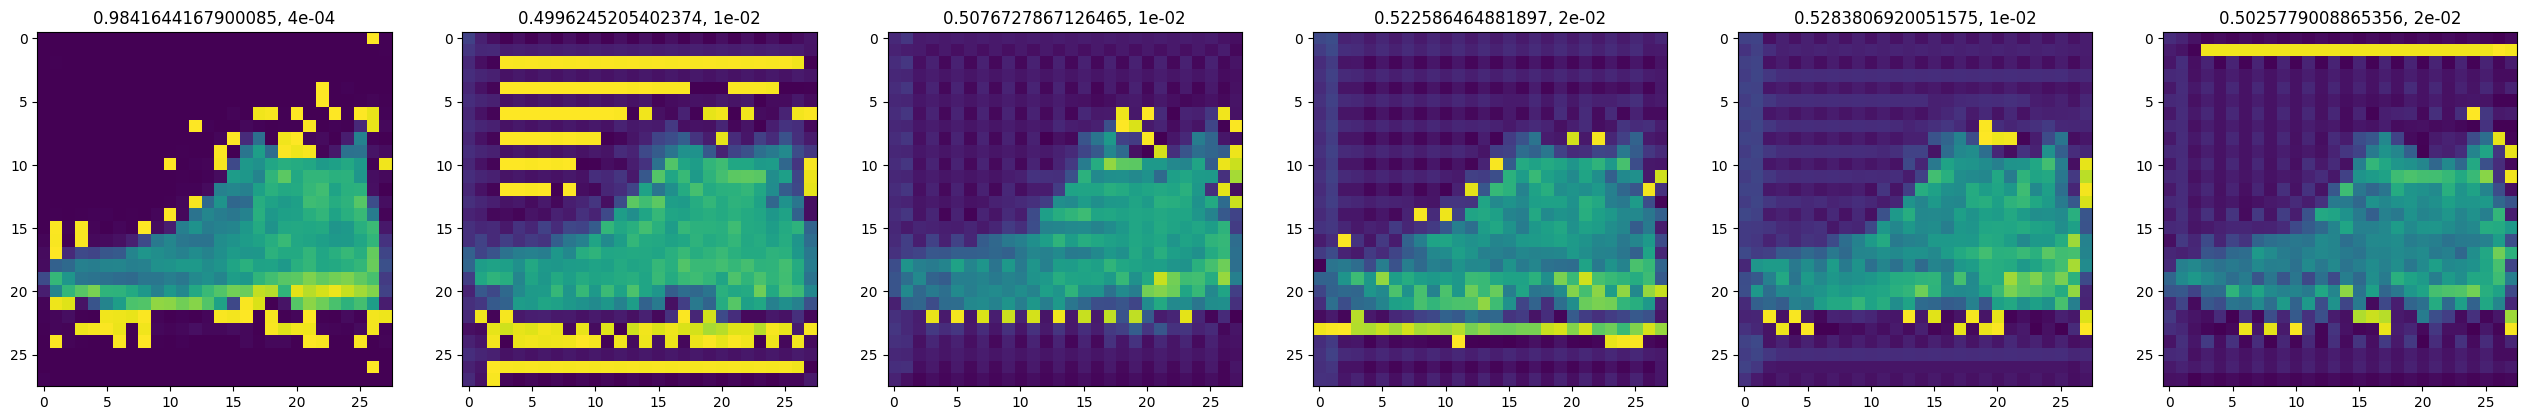

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

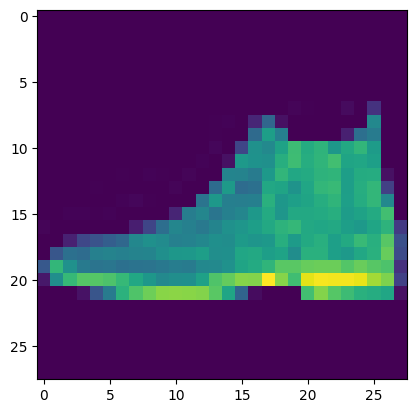

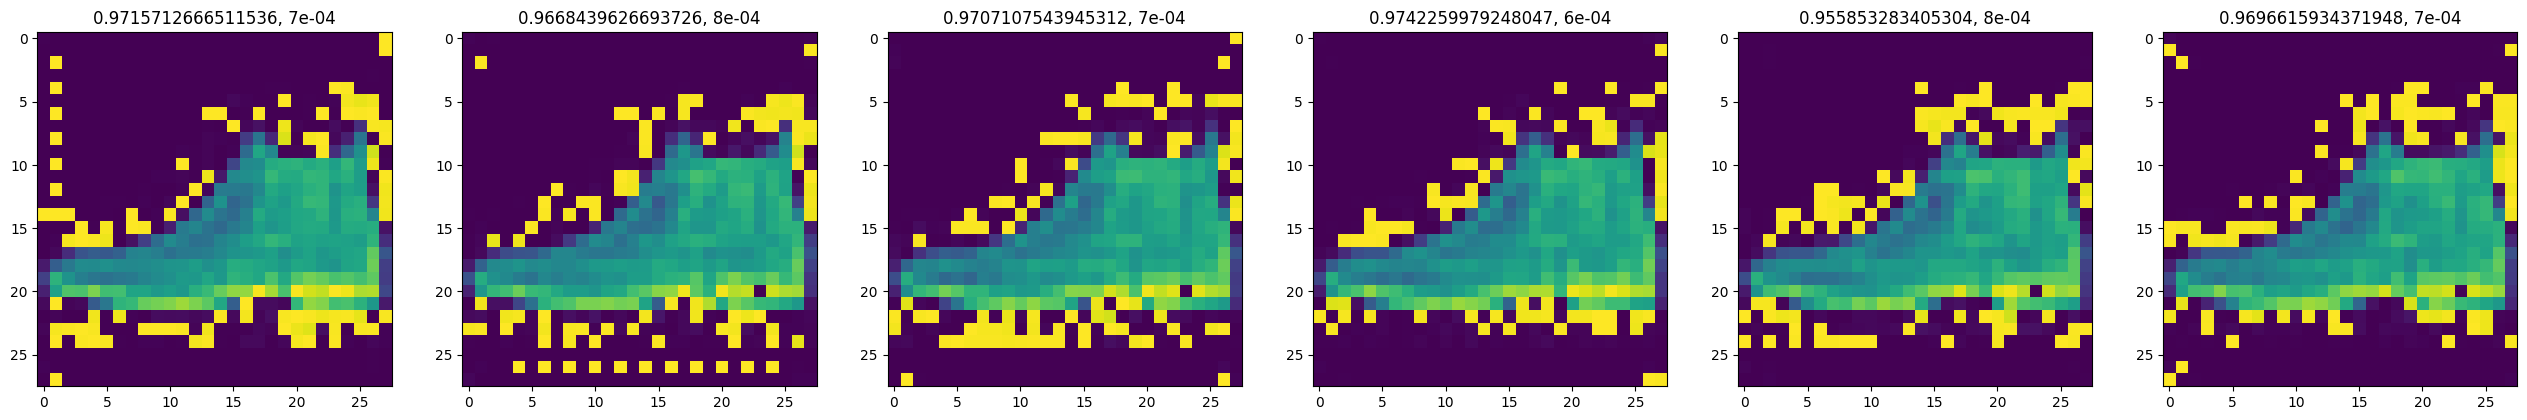

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7')
decoders = [Decoder().cuda() for c in network.clients]
for i in tqdm(range(len(network.clients))):
  j = (i + 1) % len(network.clients)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
  decoders[i].train_model(network.clients[i], network.clients[j], 30)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
reconstruct(decoders)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

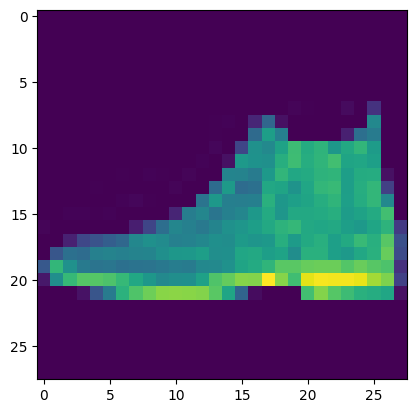

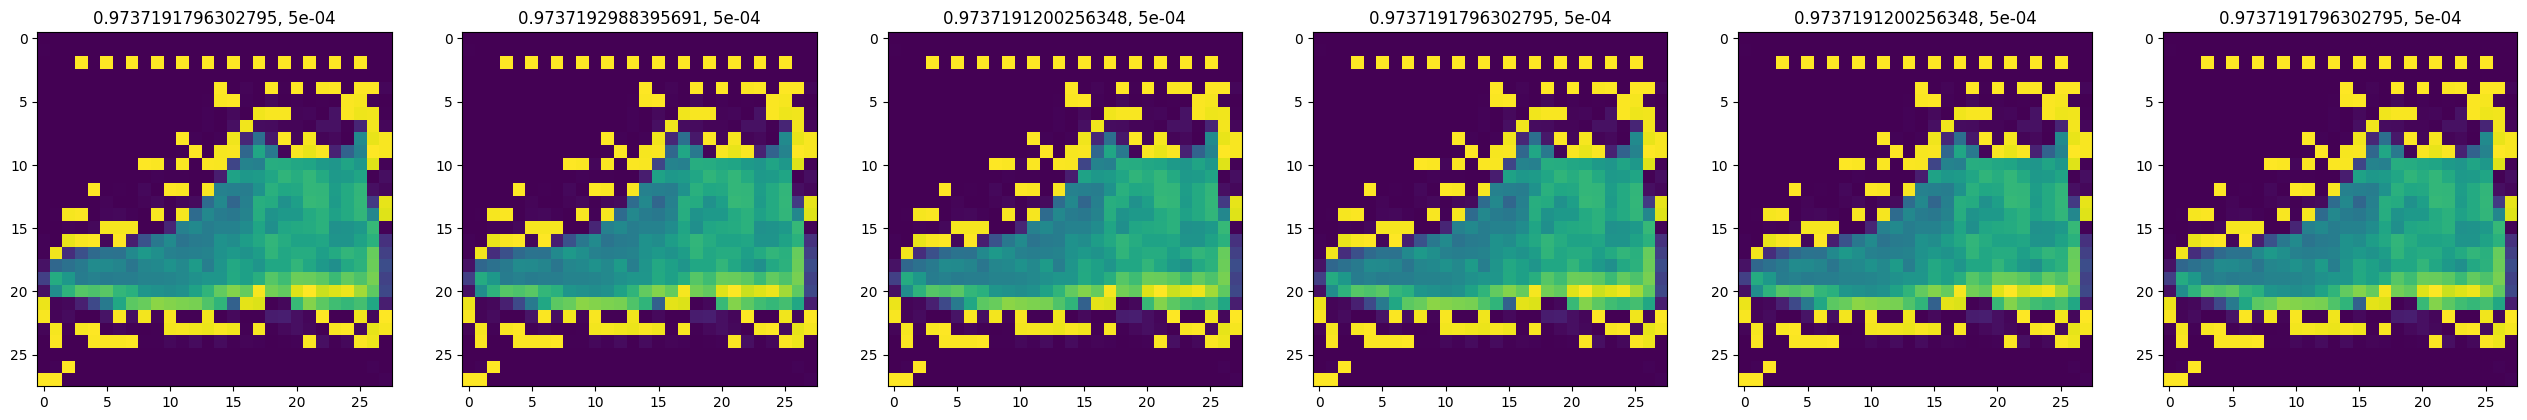

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'federate', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

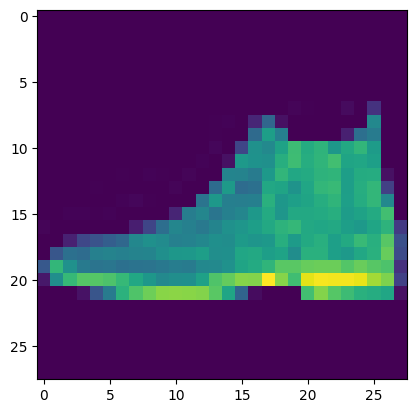

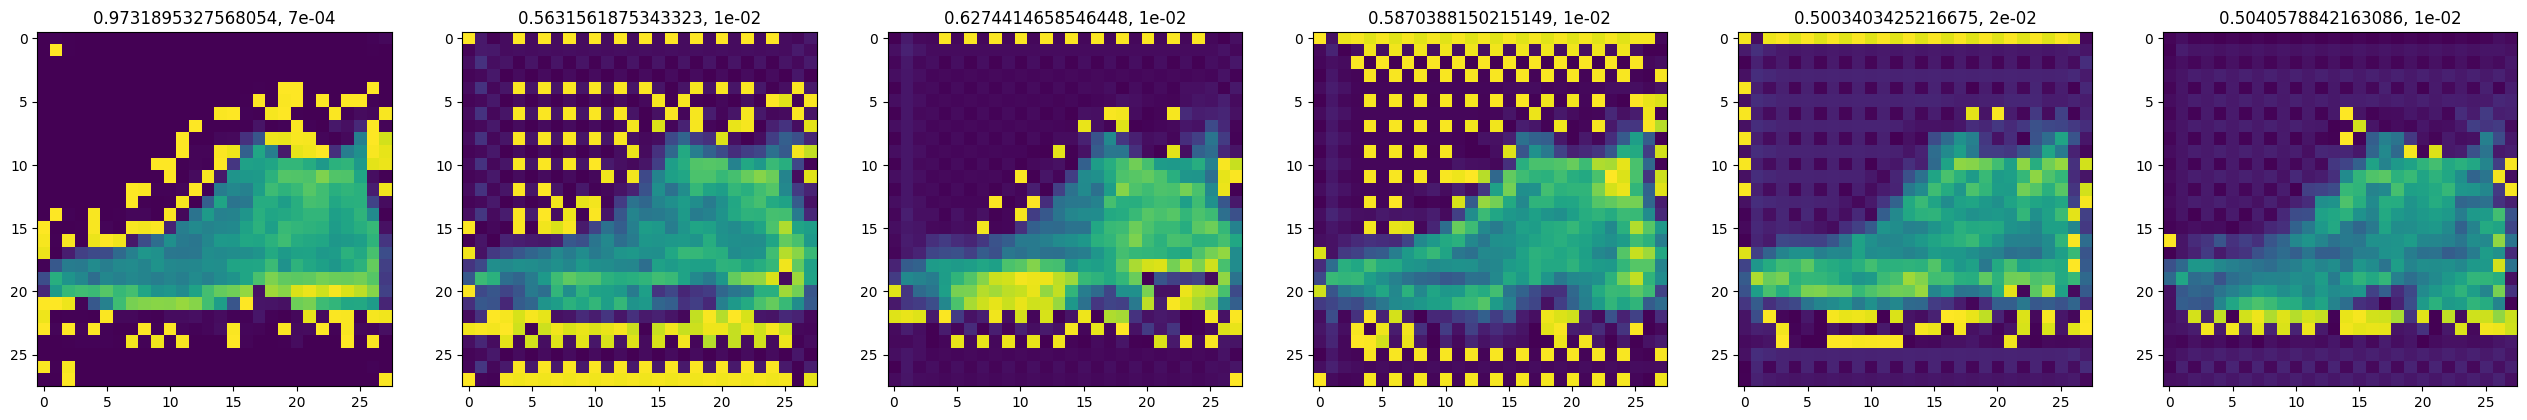

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 100, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

#Differential Privacy

In [9]:
import numpy as np
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.laplace import Laplace

class LayerDP(nn.Module):
  def __init__(self, epsilon, sensitivity, delta=0, Bound=1, Clip=True, Assert=False):
    super().__init__()
    scale = sensitivity / epsilon
    if delta > 0:
      scale = np.sqrt(2 * np.log(1.25 / delta)) * scale
    scale = torch.tensor(scale, dtype=torch.float32).cuda()
    self.noise = Normal(0, scale) if delta else Laplace(0, scale)
    self.Assert, self.sensitivity = Assert, sensitivity
    self.Bound, self.Clip = torch.tensor(Bound), Clip
    self.One = torch.tensor(1)

  def forward(self, x):
    if self.Clip:
      x = F.hardtanh(x, -self.Bound, self.Bound)
    else:
      d = x.abs().max() / self.Bound
      x = x / torch.max(self.One, d)
    
    if self.Assert:
      assert x.max() - x.min() <= self.sensitivity

    return x + self.noise.sample(x.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

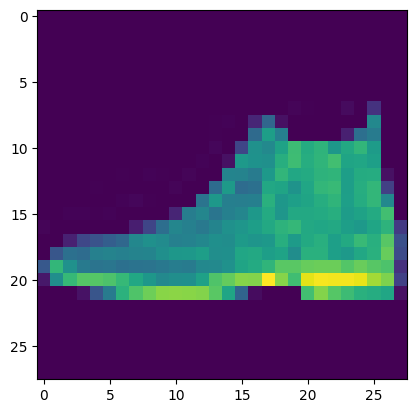

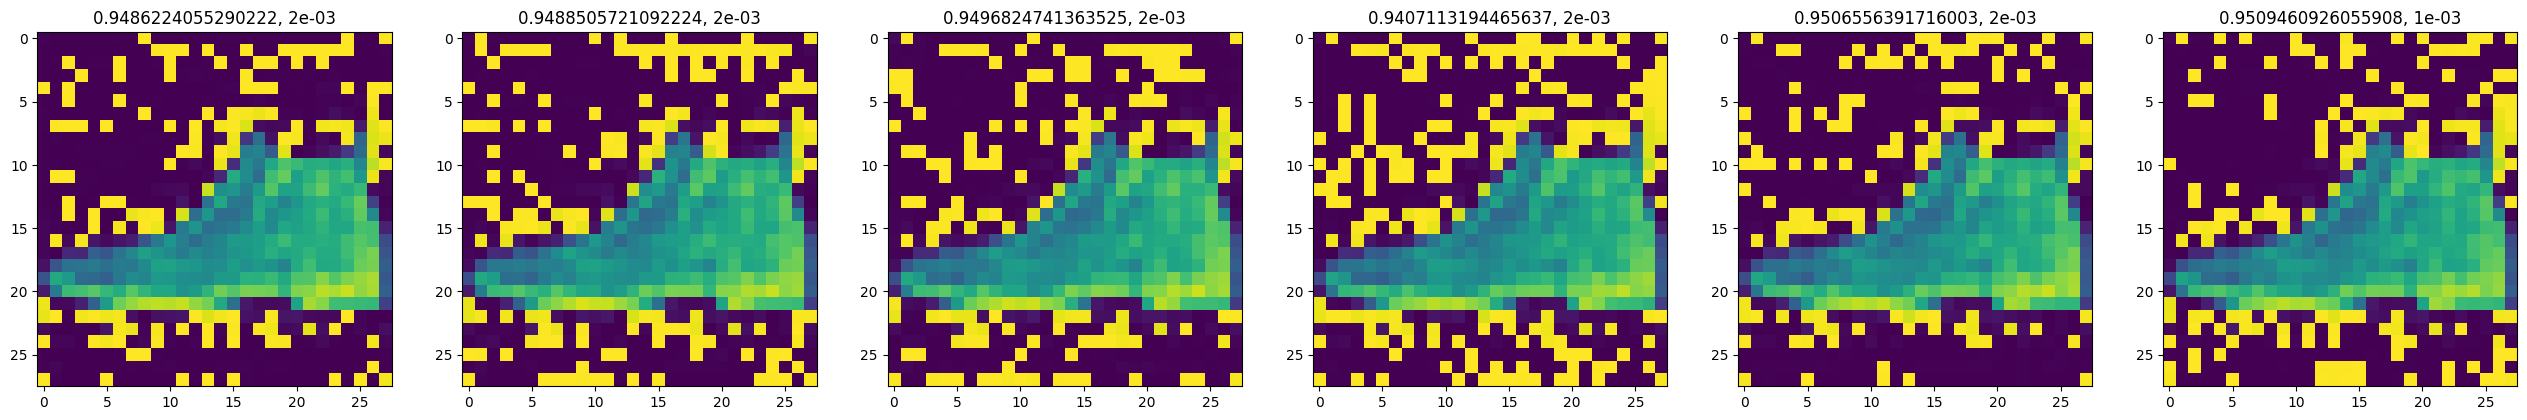

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(100, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

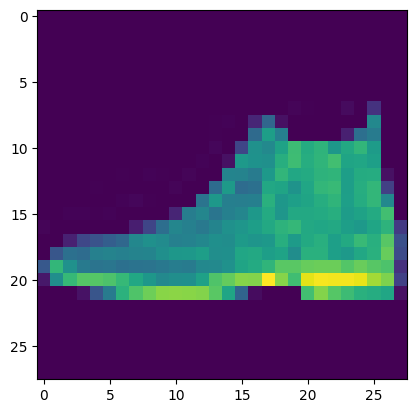

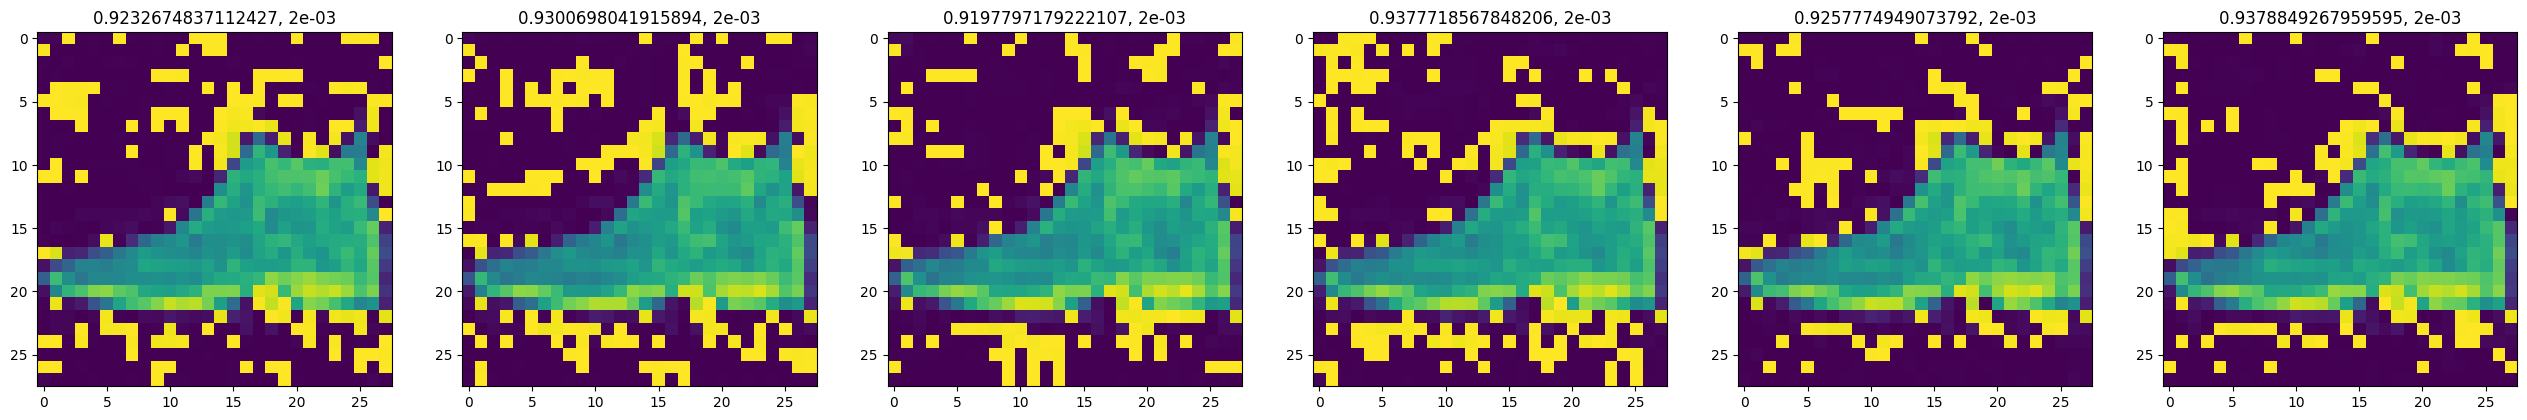

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(50, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

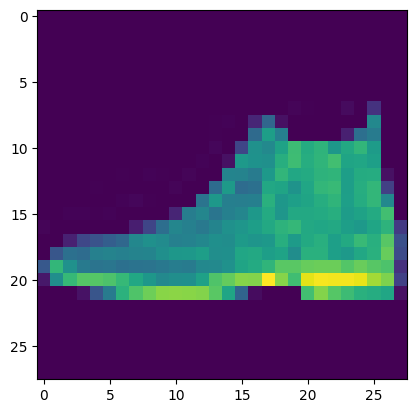

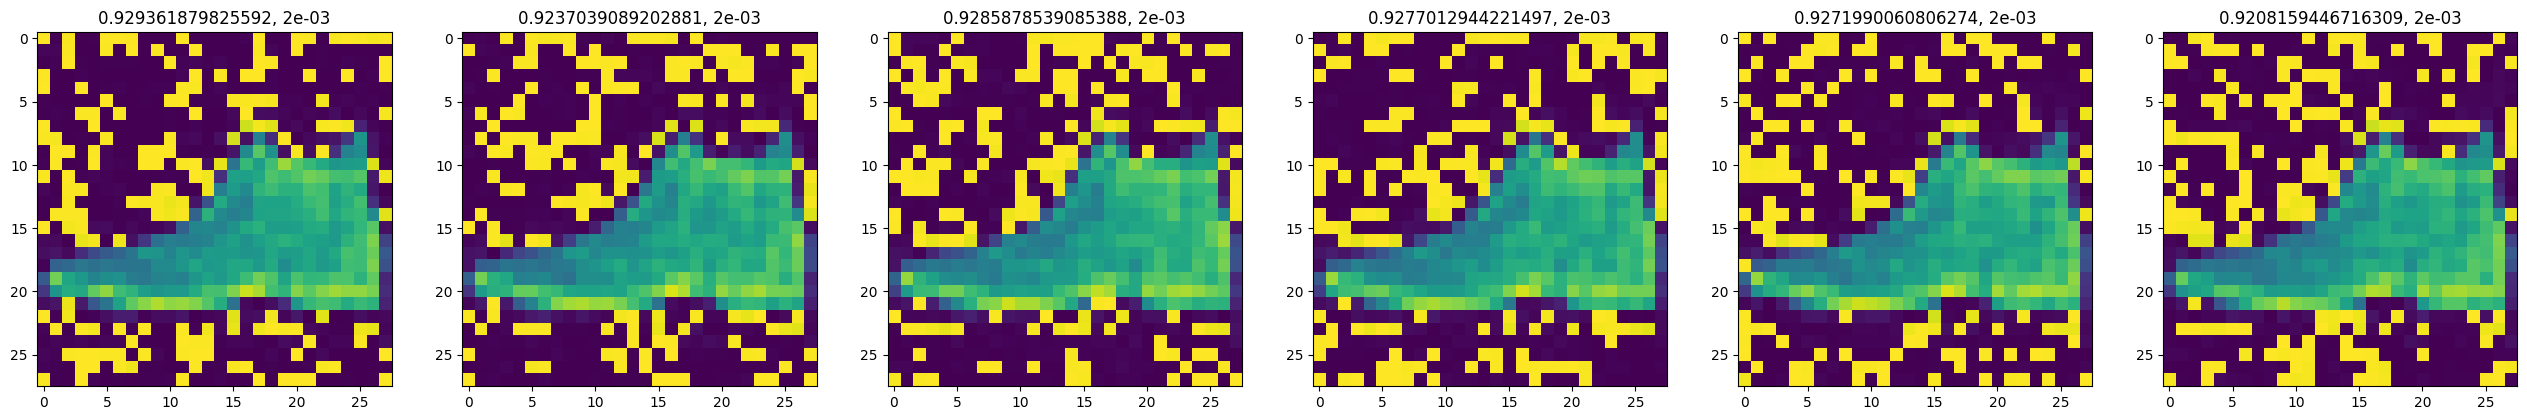

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(30, 1))

network = train_splitnn(clients, (testset, 1, 10), 'federate', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

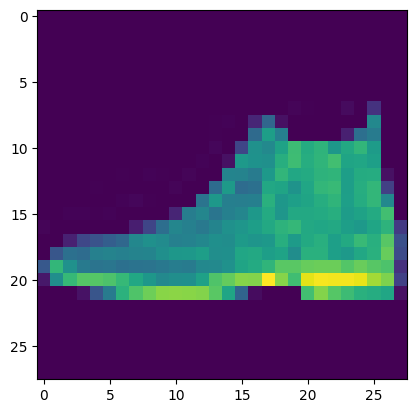

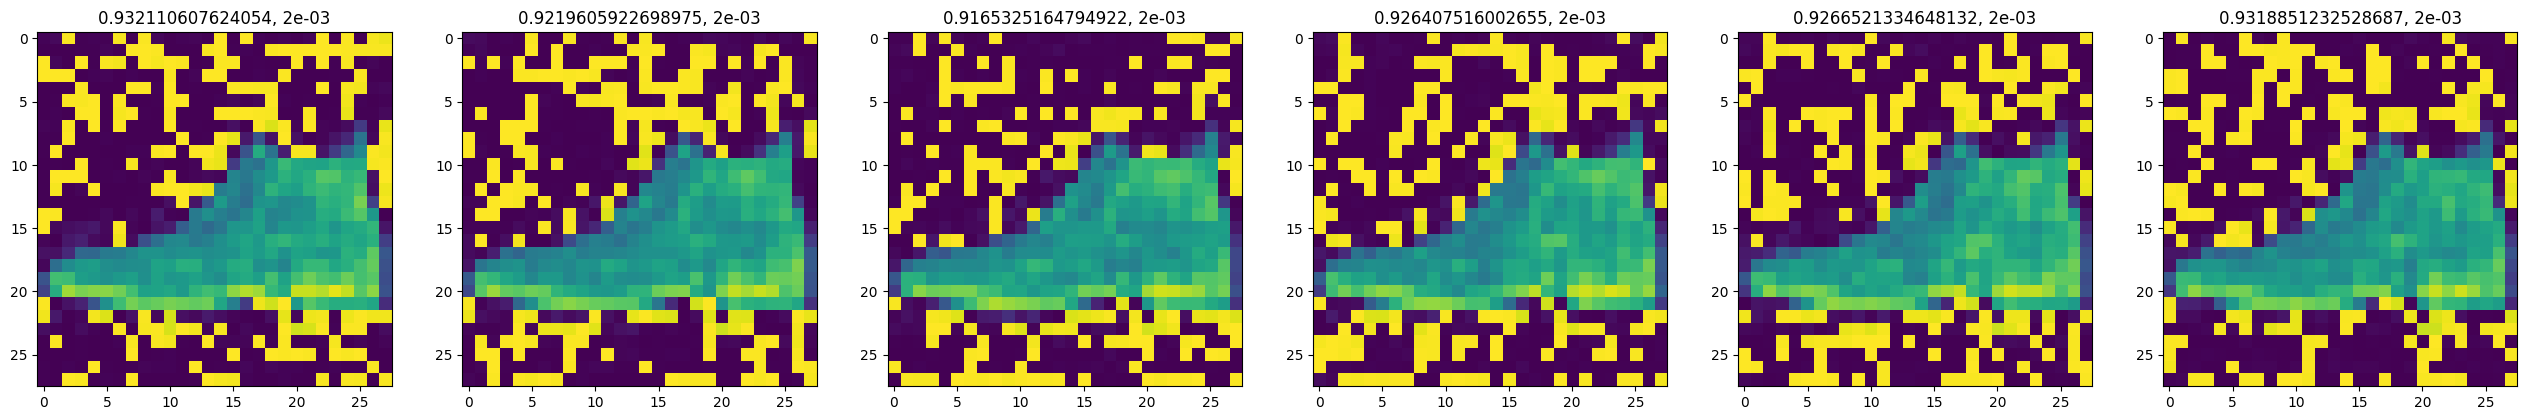

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(20, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

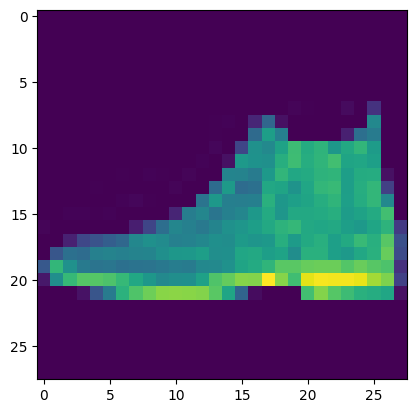

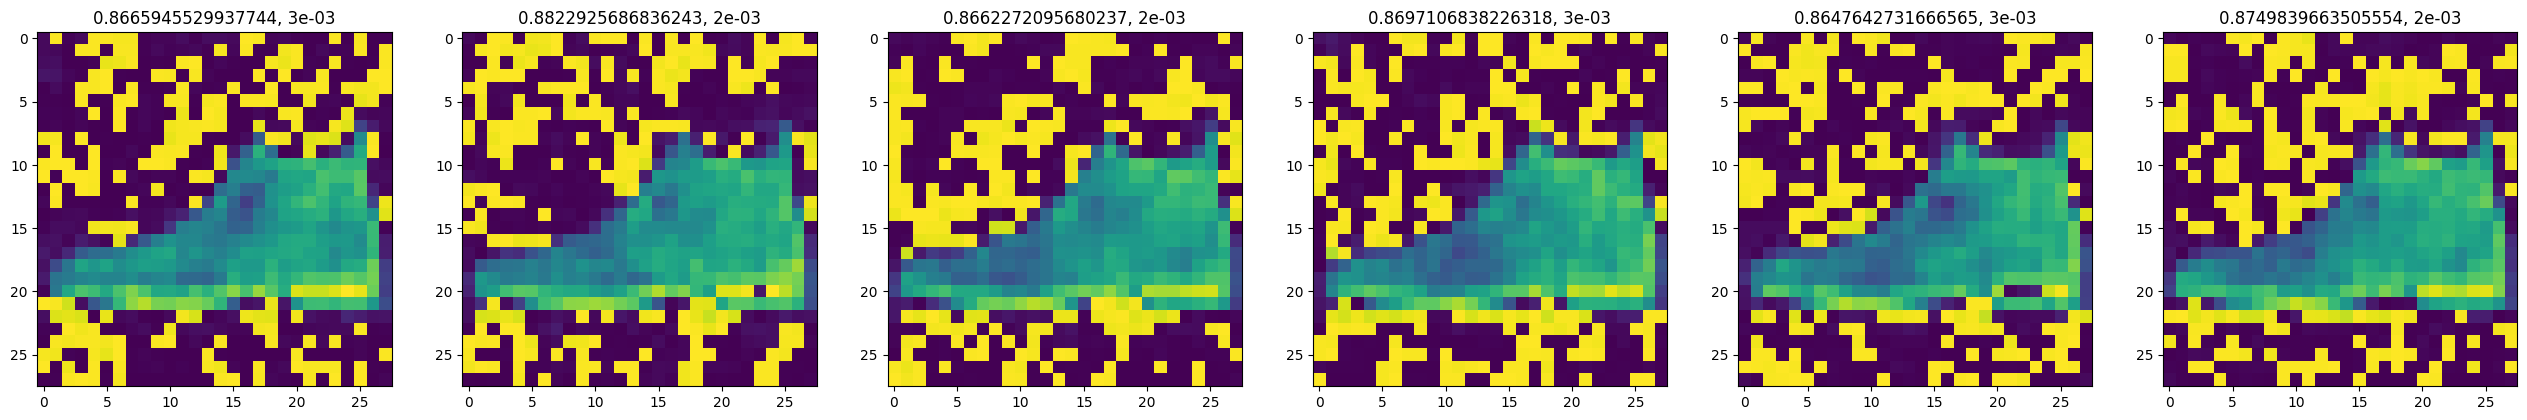

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(10, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

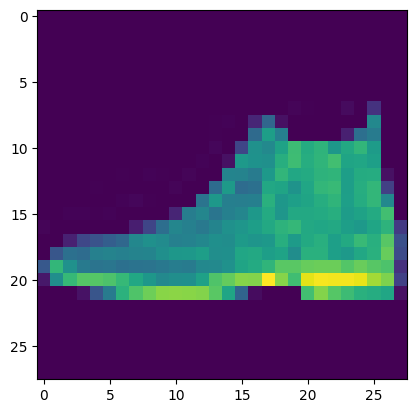

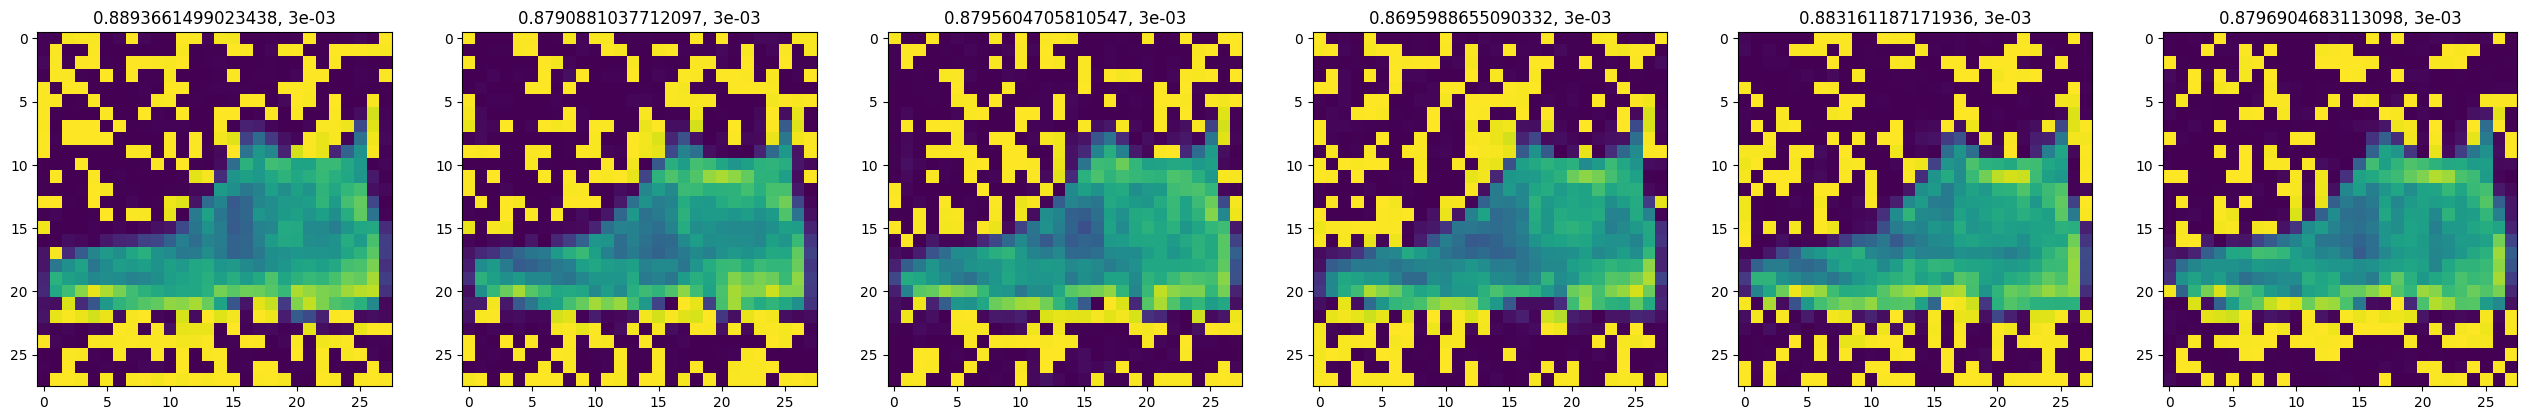

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(8, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

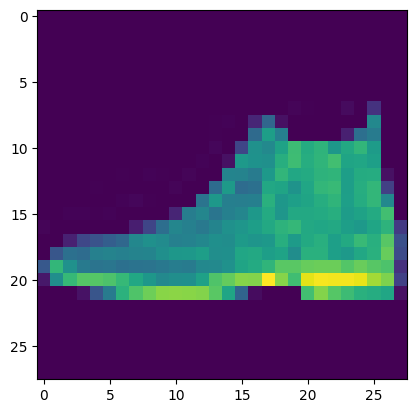

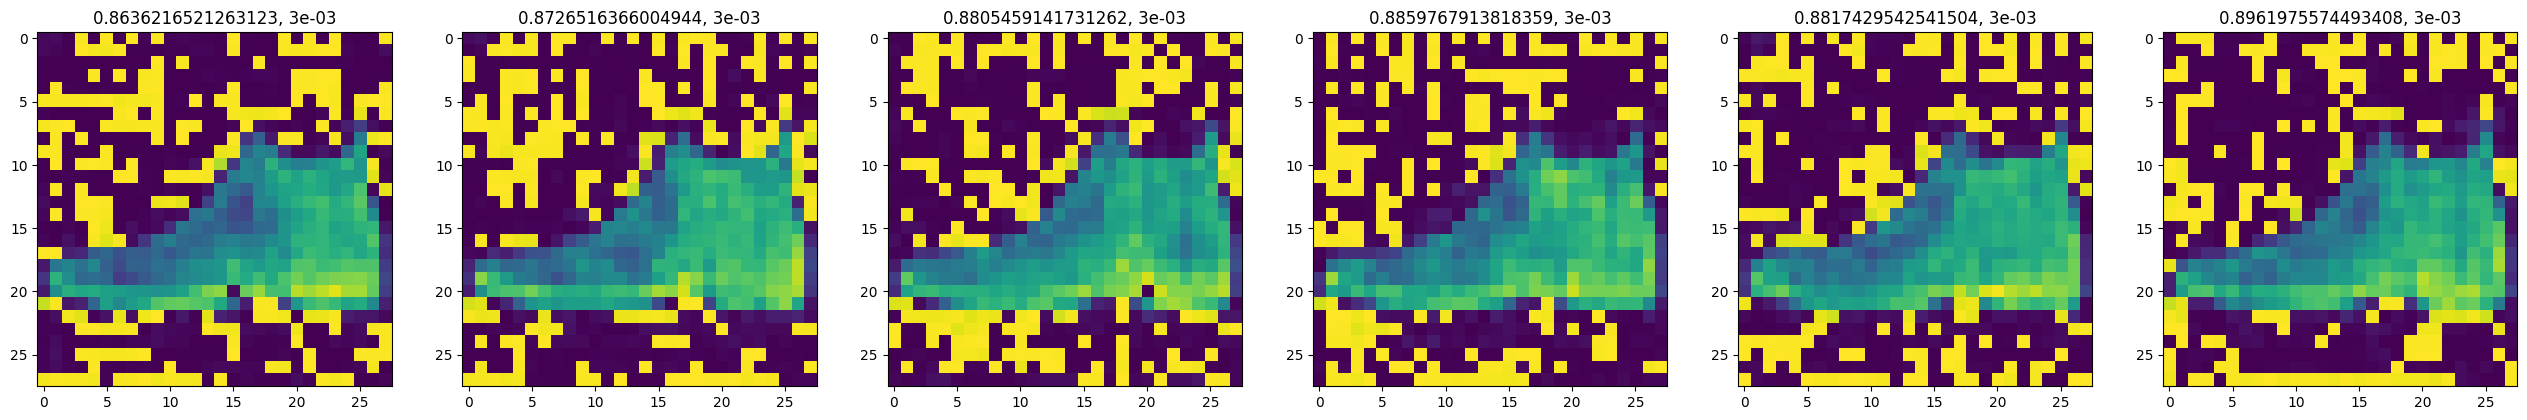

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(7, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

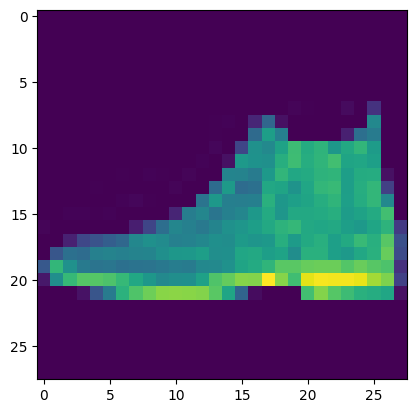

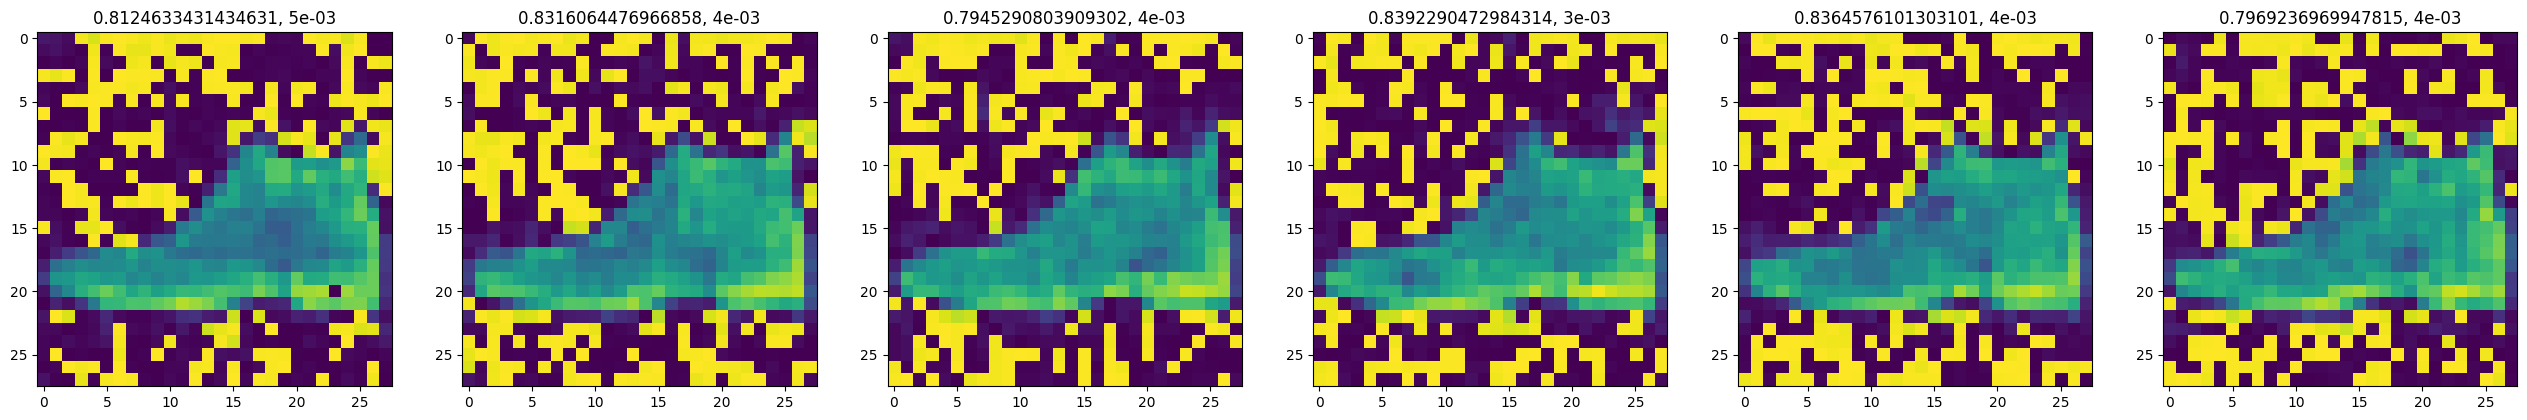

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(6, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

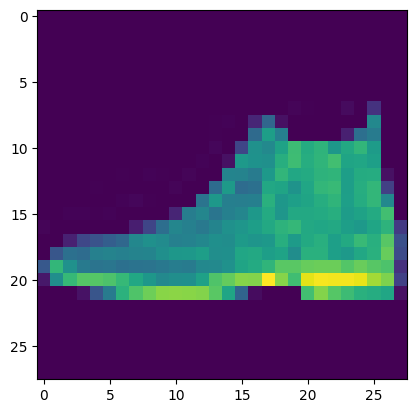

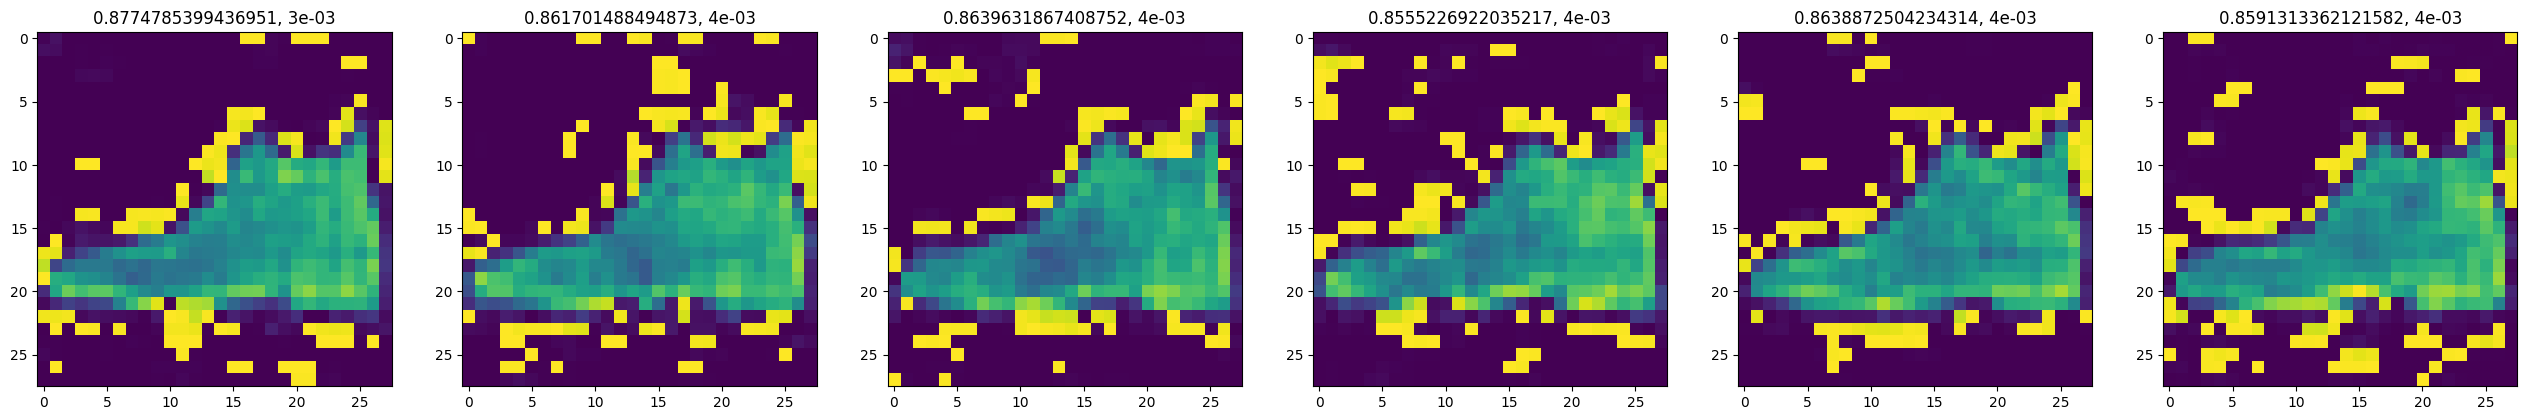

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(5, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

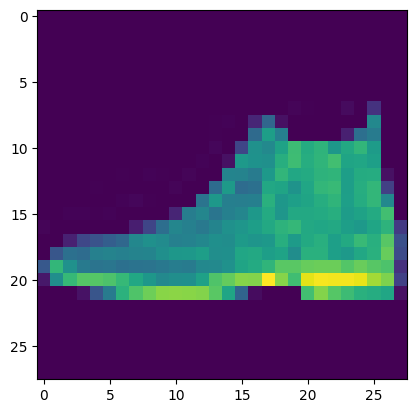

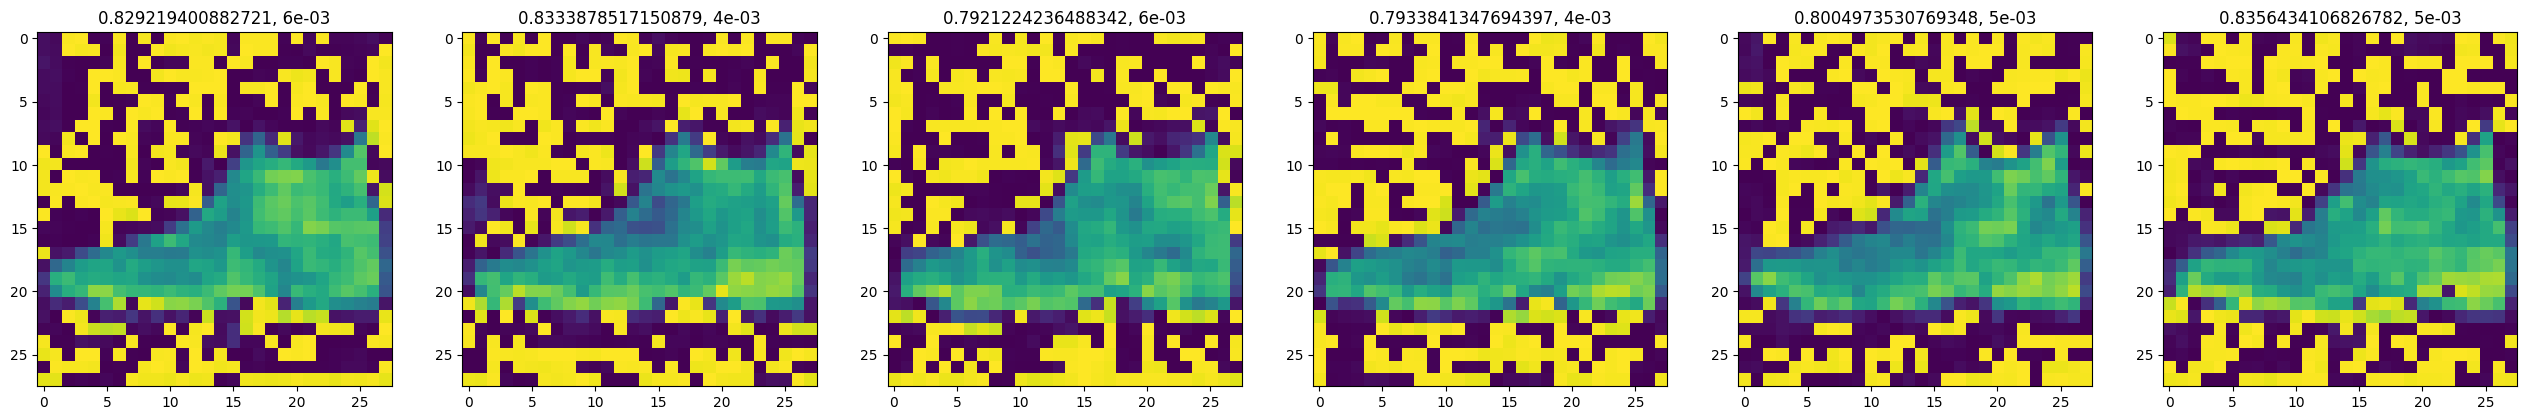

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(4, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

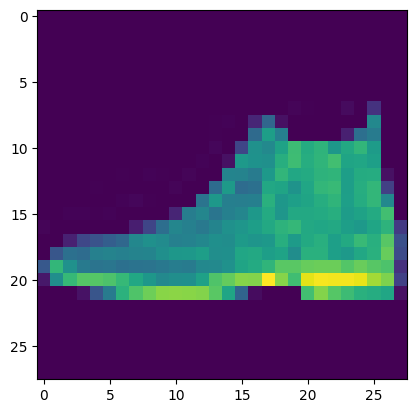

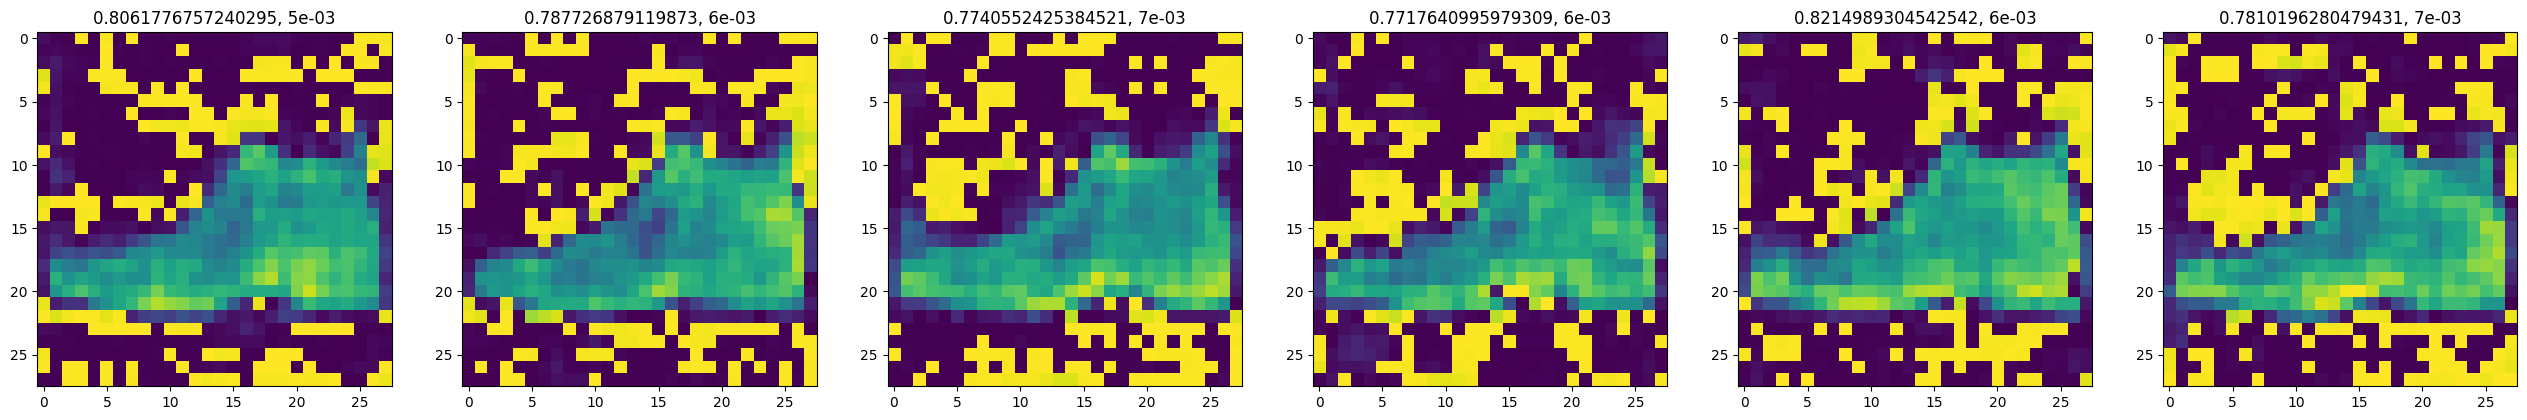

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(3, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

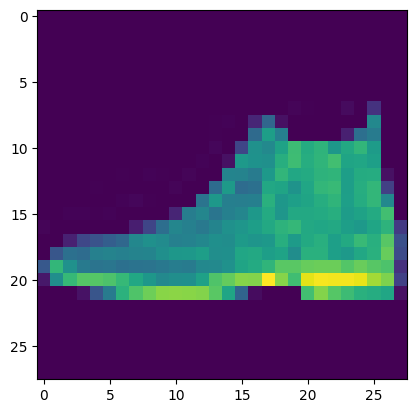

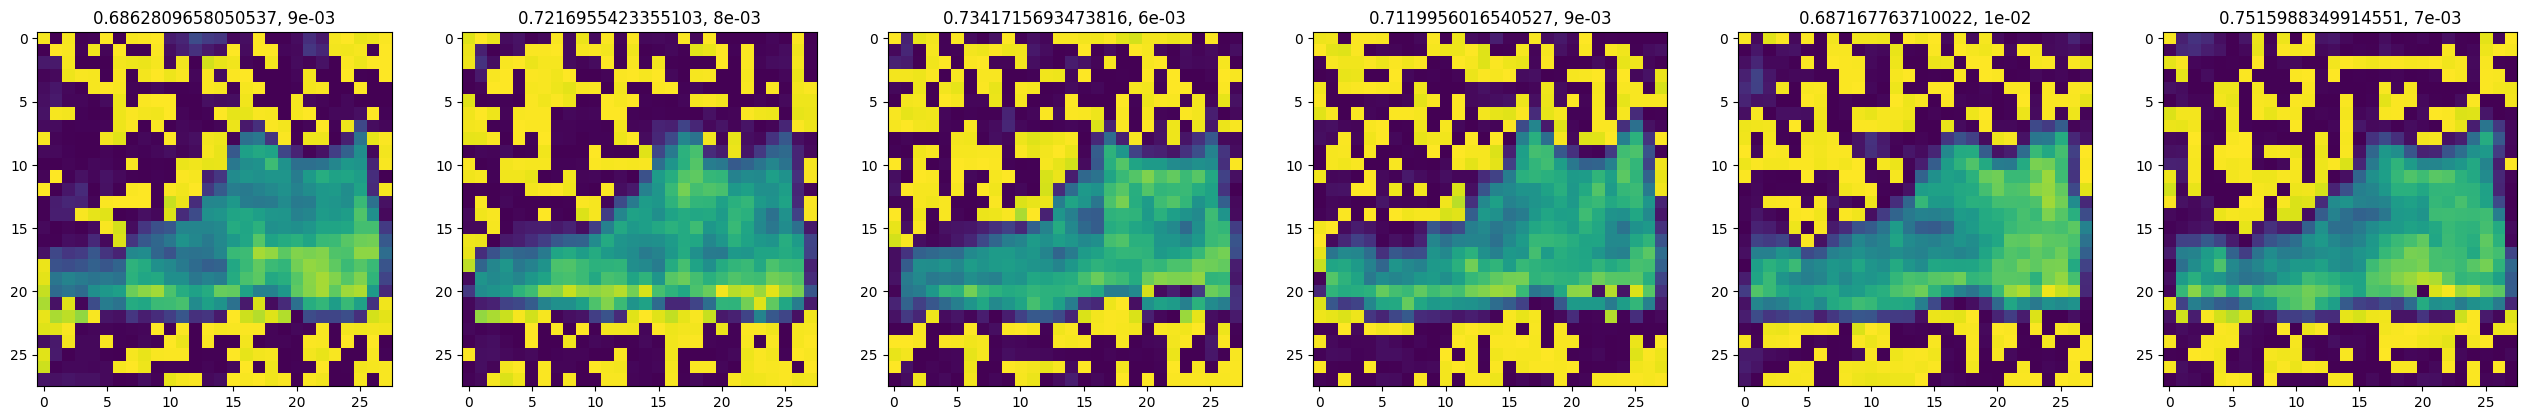

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(2, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

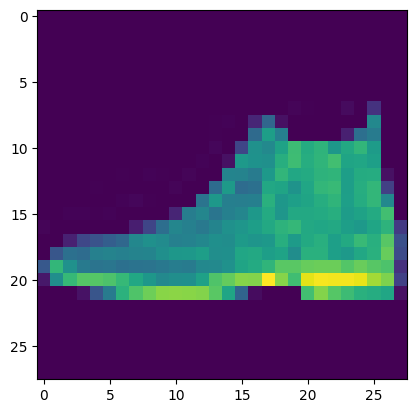

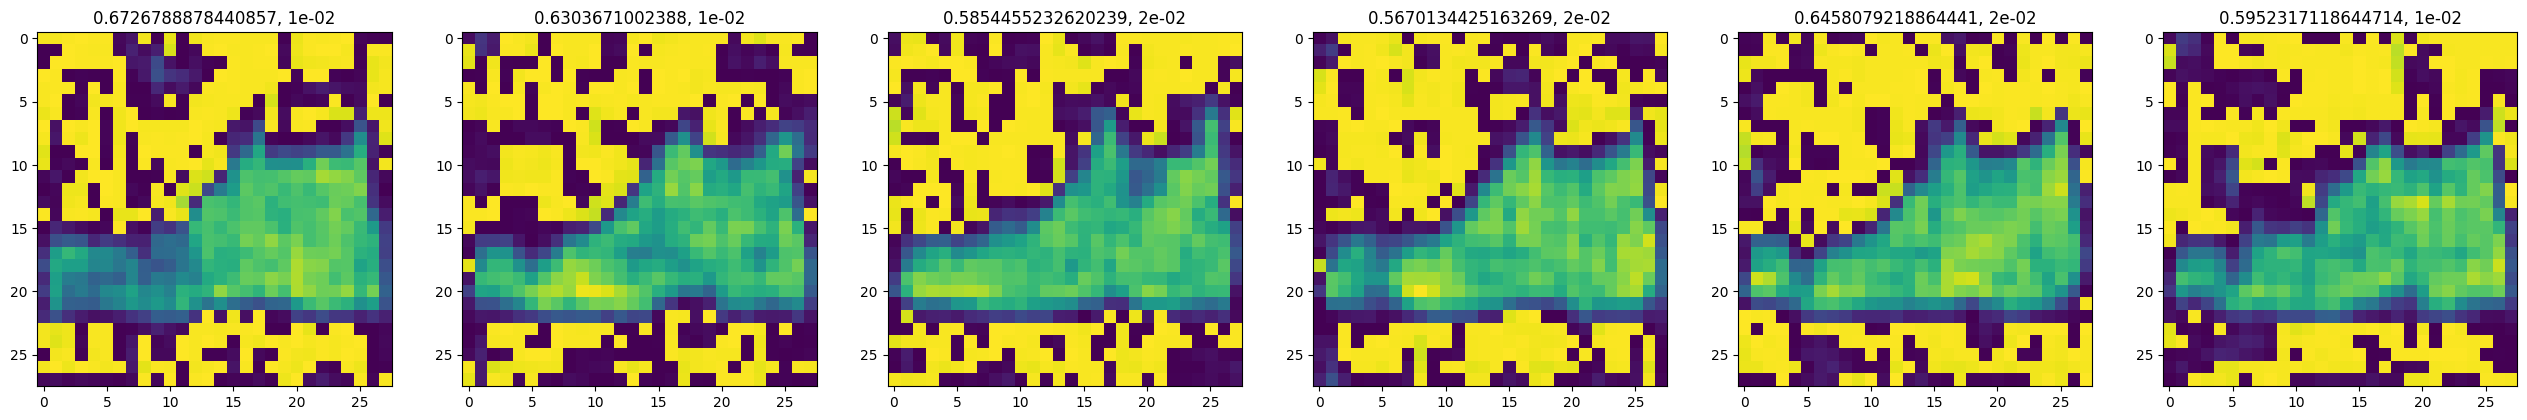

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(1.5, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

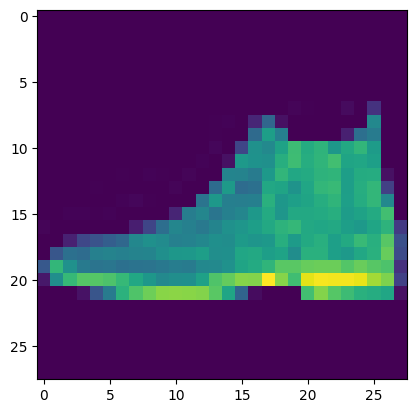

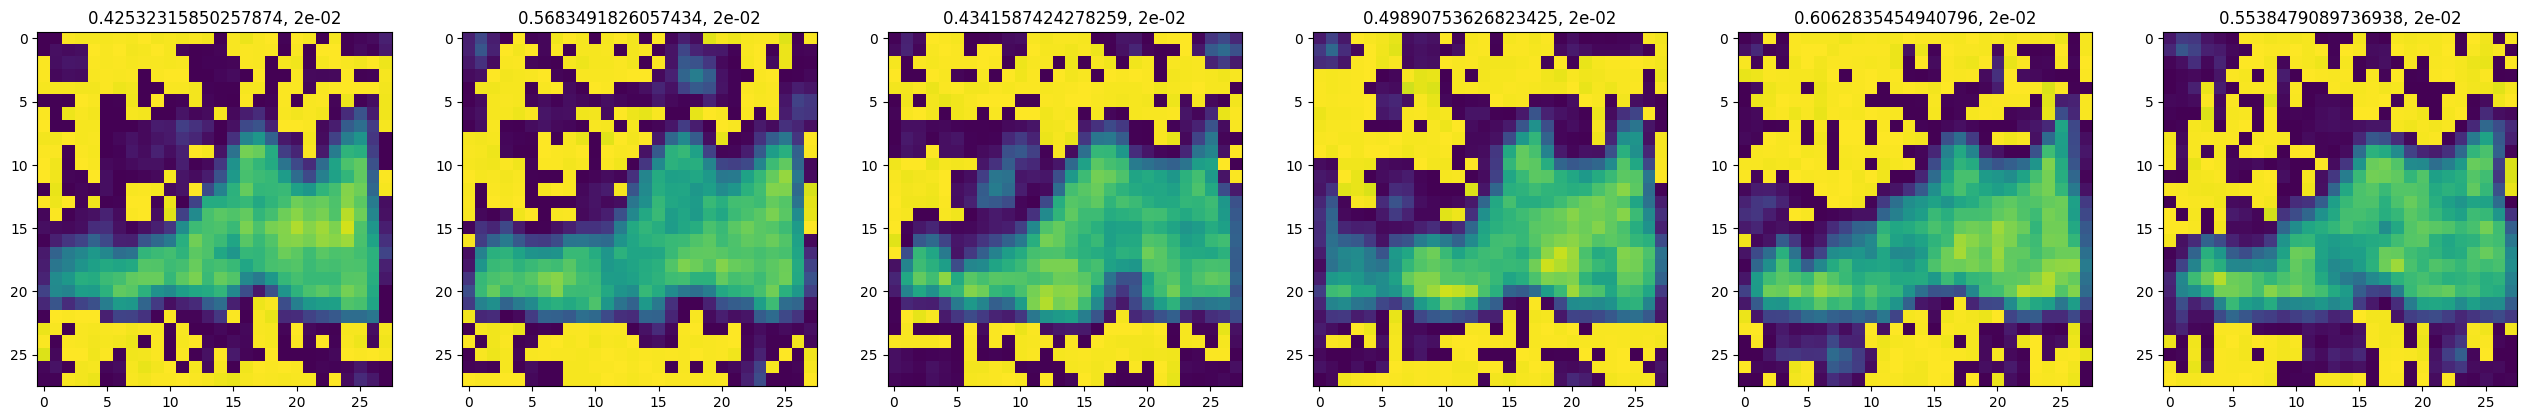

In [ ]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(1, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

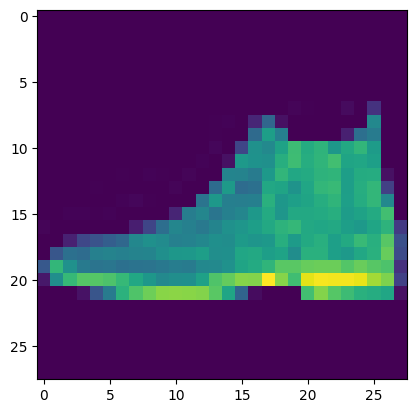

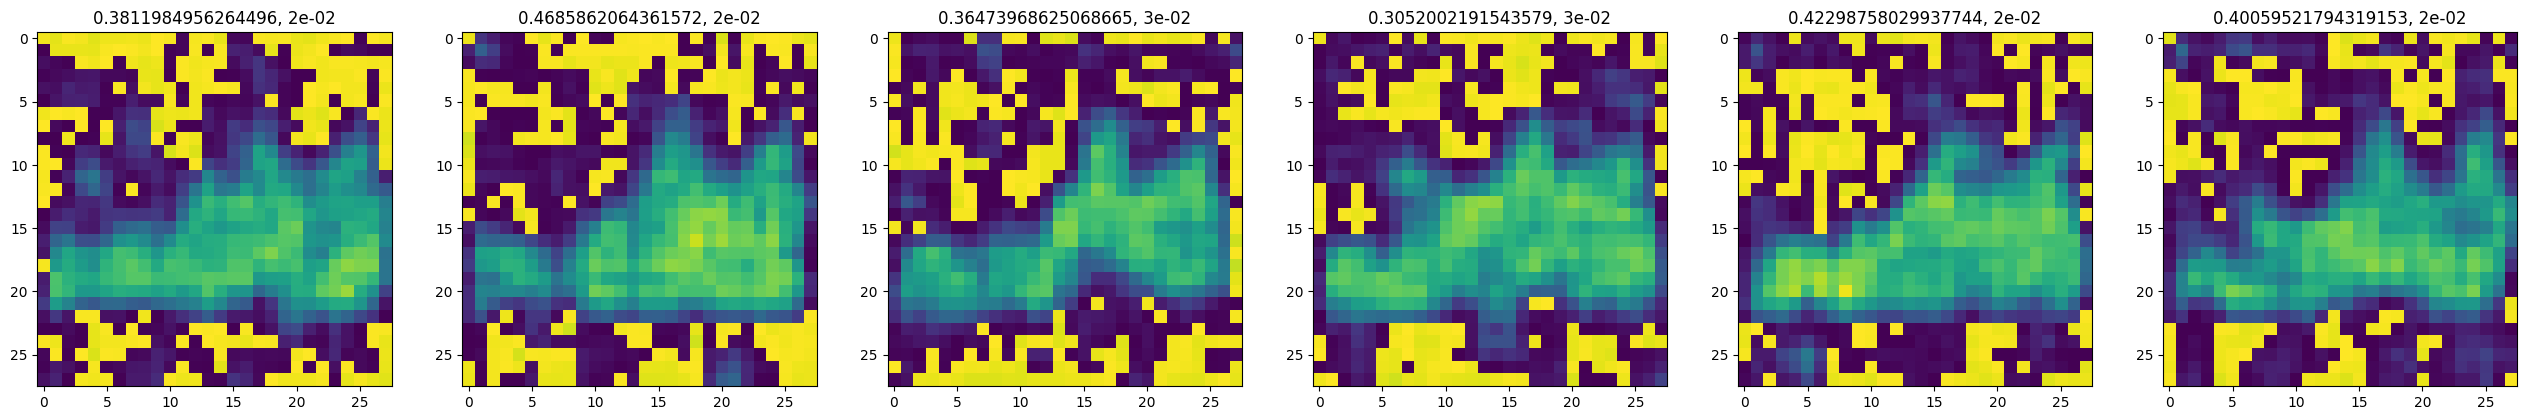

In [10]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(.7, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

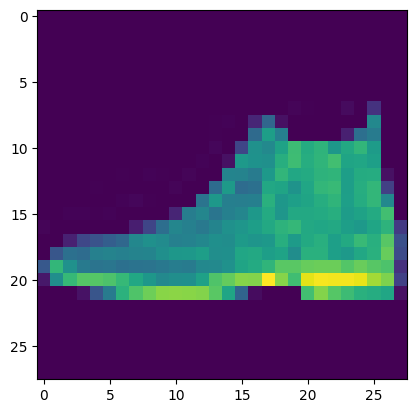

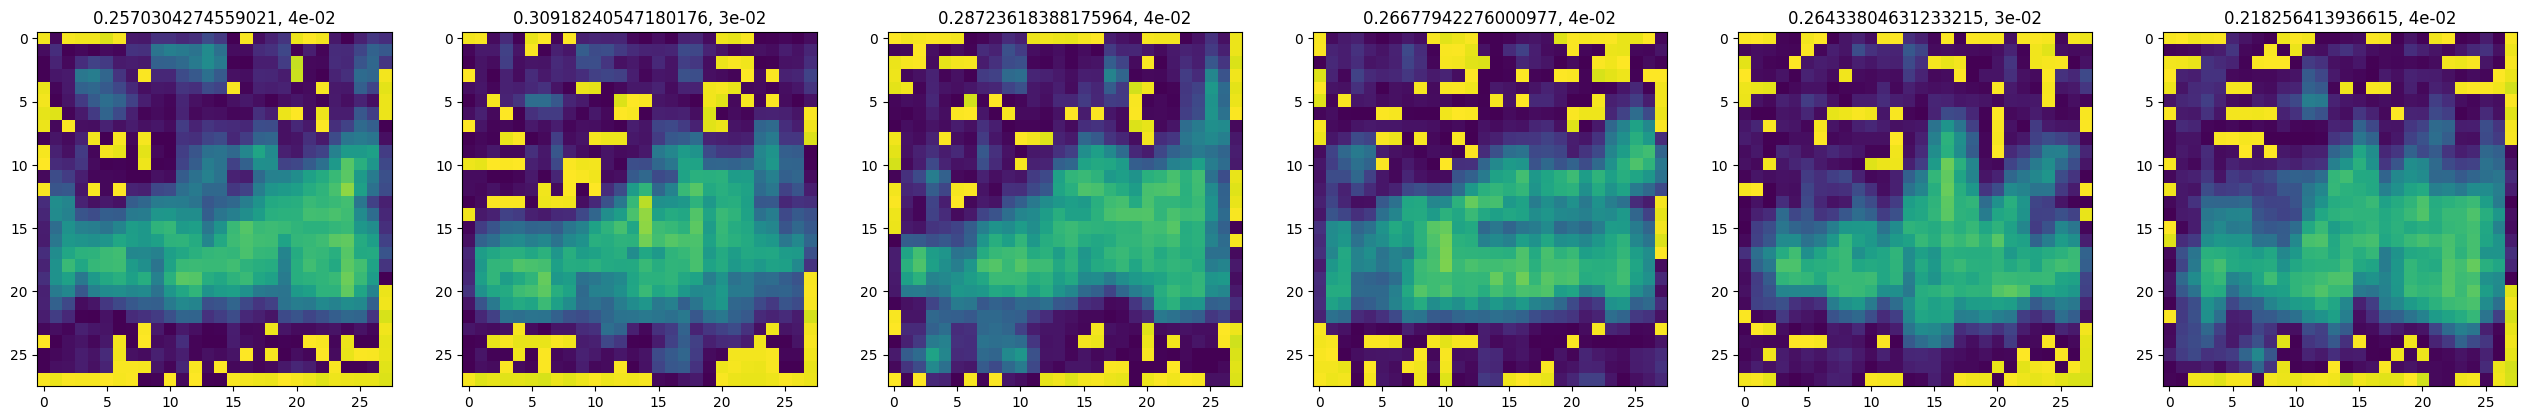

In [11]:
class VGG_7_DP(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)
    self.client.append(LayerDP(.5, 1))

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_DP')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])